Paper: https://www.andrew.cmu.edu/user/lakoglu/pubs/StackOverflow-churn.pdf

Description of datasets: https://ia800107.us.archive.org/27/items/stackexchange/readme.txt

Site for download of datasets: https://archive.org/details/stackexchange

This code has 6 steps

1. Load StackOverflow datasets as dataframe
2. Extract and label the datasets for each task
3. Extract features for each task
4. Analyze features
5. Train models for each task with the features
6. Quantify the importance of each feature category

1. Load StackOverflow datasets as dataframe

In [0]:
import sys
!{sys.executable} -m pip install xmltodict
import xmltodict

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io
import traceback

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
gdrive = GoogleDrive(gauth)

In [0]:
def store_df_at_google_drive(fname, df):
    s = io.StringIO()
    df.to_csv(s)
    uploaded = gdrive.CreateFile({'title': fname, 'parents':[{'id': 'root'}]})
    uploaded.SetContentString(s.getvalue())
    uploaded.Upload()
    print('Uploaded file with ID {}'.format(uploaded.get('id')))

def load_df_at_google_drive(fname):
    file_list = gdrive.ListFile({'q': "'root' in parents and trashed=false"}).GetList()
    for file1 in file_list:
        if (file1['title'] == fname):
            downloaded = gdrive.CreateFile({'id': file1['id']})
            s = io.StringIO(downloaded.GetContentString())
            return pd.read_csv(s)
    
def load_dataset_from_google_drive(dir_id):
    files = []
    file_list = gdrive.ListFile({'q': "'{}' in parents".format(dir_id)}).GetList()
    for f in file_list:
      if f['title'] in ['Users.xml', 'Posts.xml','users_reduce.pkl', 'posts_reduce.pkl']:
        print('  Load file: {}'.format(f['title']))
        f_ = gdrive.CreateFile({'id': f['id']})
        f_.GetContentFile(f['title'])
        files.append(f['title'])
    return files

In [0]:
files = load_dataset_from_google_drive('1Fp_7GDH_t7xfnU8aXeKrcBC54_nECOcu') 

  Load file: users_reduce.pkl
  Load file: posts_reduce.pkl


In [0]:
users_df = pd.read_pickle("{}.pkl".format('users_reduce'))   # shape: (992,110, 3)
posts_df = pd.read_pickle("{}.pkl".format('posts_reduce'))   # shape: (11,324,326, 10)

users_df.shape, posts_df.shape   # Total dataset

((992110, 3), (11324326, 10))

2. Extract and label the datasets for each tasks

You should extract the dataset for the period of the dataset: July 31, 2008 ~ July 31, 2012

There are 2 tasks:

A. After a user's K-th post, predict how likely it is that the user will churn

B. After the T-th day from the account creation of a user, predict how likely it is that the user will churn

In [0]:
posts_df['PostId'] = posts_df.index

In [0]:
# Eliminate posts except questions and answers
posts_df = posts_df[(posts_df['PostTypeId'] == 1) | (posts_df['PostTypeId'] == 2)]

In [0]:
# Extract the dataset for the period of the dataset: July 31, 2008 - July 31, 2012
start_time = pd.to_datetime('2008-07-31')
end_time = pd.to_datetime('2012-07-31')
end_time_2 = pd.to_datetime('2012-01-31')
posts_df = posts_df[(posts_df['CreationDate'] >= start_time) & (posts_df['CreationDate'] <= end_time)]
users_df = users_df[(users_df['CreationDate'] >= start_time) & (users_df['CreationDate'] <= end_time_2)]

In [0]:
# 1. Eliminate answers which do not have the question
# 2. If a answer is faster than question of it, eliminate the answer

questions = posts_df[posts_df['PostTypeId'] == 1]
answers = posts_df[posts_df['PostTypeId'] == 2]
print(answers.shape)
print(questions.shape)


qna = answers.set_index('ParentId')\
        .join(questions, how='inner',\
              lsuffix='A', rsuffix='Q')
print(qna.shape)

qna = qna[qna['CreationDateA'] >= qna['CreationDateQ']]
qna = qna[['PostIdA']]
print(qna.shape)

qna = qna.set_index('PostIdA')

answers = answers.join(qna, how='inner', lsuffix='', rsuffix='Q')
print(answers.shape)

posts_df = pd.concat([questions, answers])
posts_df = posts_df.set_index('PostId')
posts_df['PostId'] = posts_df.index
print(posts_df.shape)

(6396879, 11)
(3102286, 11)
(6152783, 21)
(6152120, 1)
(6152120, 11)
(9254406, 11)


In [0]:
# For each post, calculate the order of it
def getIthOfPosts(posts):
    try:
      print('getIthOfPosts')
      posts = posts.sort_values(by=['OwnerUserId', 'CreationDate'])
      posts = posts.reset_index(level=0, drop=True)
      posts['id_owner_time'] = posts.index
      first_posts = posts.groupby('OwnerUserId')['id_owner_time'].min().to_frame()
      tmp = posts.join(first_posts, on='OwnerUserId', how='inner', lsuffix='F', rsuffix='P')
      posts['ith'] = tmp['id_owner_timeF'] - tmp['id_owner_timeP'] + 1
      posts = posts.drop(['id_owner_time'], axis=1)
      return posts
    except:
      print(traceback.format_exc())

posts_df = getIthOfPosts(posts_df)
posts_df.set_index('PostId')
posts_df['PostId'] = posts_df.index

getIthOfPosts


In [0]:
# Dataset in Task 1
#   Posts: Extract K posts of each user
#   Users: Extract users who post at least K


def getTask1Posts(posts, K):
    tmp = posts[posts['ith'] == K]['OwnerUserId'].to_frame()
    tmp = tmp.set_index('OwnerUserId')
    tmp = posts[posts['OwnerUserId'].isin(tmp.index)]
    return tmp[tmp['ith'] <= K]


def getTask1Users(users, posts, K):
    users['num_posts'] = posts.groupby('OwnerUserId')['OwnerUserId'].count()
    users = users[users['num_posts'] >= K]
    return users


In [0]:
list_of_K = range(1, 21)
users_of_task1, posts_of_task1 = {}, {}


for K in list_of_K:
    posts_of_task1[K] = getTask1Posts(posts_df, K)
    users_of_task1[K] = getTask1Users(users_df, posts_df, K)

In [0]:
# Churn in Task 1
#   Churners: Users who did not post for at least 6 months from their K-th post 
#   Stayers:  Users who created at least one post within the 6 months from their K-th post

def prepareFeaturesTask1(users, posts, K):
    tmp = posts[posts['ith']==K]['OwnerUserId'].to_frame()
    tmp = tmp.set_index('OwnerUserId')
    posts = posts[posts['OwnerUserId'].isin(tmp.index)]

    posts_task = posts[posts['OwnerUserId'].isin(users.index)]
    posts_Kth_time = posts_task[posts_task['ith']==K]
    posts_Kth_time = posts_Kth_time.set_index('OwnerUserId')['CreationDate']
    posts_deadline = posts_Kth_time + pd.tseries.offsets.DateOffset(months=6)
    
    posts_stayer = posts_task[posts_task['ith'] > K].groupby('OwnerUserId')['CreationDate'].min().to_frame()
    posts_stayer = posts_stayer.merge(posts_deadline, on='OwnerUserId', how='left', suffixes=('_left', '_right'))
    
    posts_churner1 = posts_stayer[posts_stayer['CreationDate_left'] > posts_stayer['CreationDate_right']]
    posts_churner1['is_churn'] = 1
    posts_churner1 = posts_churner1[['is_churn']]
    posts_stayer = posts_stayer[posts_stayer['CreationDate_left'] <= posts_stayer['CreationDate_right']]
    posts_stayer['is_churn'] = 0    
    posts_stayer = posts_stayer[['is_churn']]
       
    posts_churner2 = posts_task[posts_task['ith'] >= K].groupby('OwnerUserId').count()
    posts_churner2 = posts_churner2[posts_churner2['CreationDate'] == 1][['CreationDate']]
    posts_churner2['is_churn'] = 1
    posts_churner2 = posts_churner2[['is_churn']]
    
    posts = pd.concat([posts_stayer, posts_churner1, posts_churner2])
    posts = posts.rename(columns={'OwnerUserId': 'Id'})
    users['is_churn'] = 0
    users.update(posts)
    return users

features_of_task1 = {}
features_before = None
a = False

for K in list_of_K:
    if a:
        users_of_task1[K] = features_before[features_before['is_churn'] == 0]
    features_of_task1[K] = prepareFeaturesTask1(users_of_task1[K], posts_df, K)
    users_of_task1[K] = features_of_task1[K]
    features_before = features_of_task1[K]
    a = True
  

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/ind

No handles with labels found to put in legend.


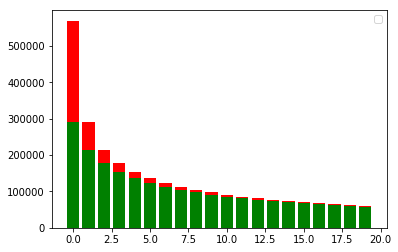

In [0]:
# Figure 1: Histogram of churning and staying users by post count (up to 20)
num_churners = []
num_stayers = []

for K in list_of_K:
  features = features_of_task1[K]
  nums = list(features.groupby('is_churn')['is_churn'].count())
  num_churners.append(nums[1])
  num_stayers.append(nums[0])

colorList=['g','r']
y = np.array([num_stayers, num_churners])


for i in range(y.shape[0]):
  plt.bar(np.arange(y.shape[1]), y[i], bottom=np.sum(y[:i], axis=0), color=colorList[(i % len(colorList))])
plt.legend()
plt.show()


In [0]:
# Dataset in Task 2
#   Users: Extract users who post at least 1
#   Posts: Extract posts which create before T day from the account creation of the owner

def getCreationDateOfOwner(users, posts):
    posts['DataframeIndex'] = posts.index
    posts['CreationDateOfOwner'] = posts.set_index('OwnerUserId')\
            .join(users, how='inner', rsuffix='OfOwner')\
            .set_index('DataframeIndex')['CreationDateOfOwner']
    posts = posts.drop(['DataframeIndex'], axis=1)
    return posts['CreationDateOfOwner']

  
def getTask2Posts(users, posts, T):
    if 'CreationDateOfUser' not in posts.columns:
        posts['CreationDateOfOwner'] = getCreationDateOfOwner(users, posts)
    observation_deadline = posts['CreationDateOfOwner'] + pd.offsets.Day(T)
    posts = posts[posts['CreationDate'] <= observation_deadline]
    return posts
  
def getTask2Users(users, posts):
    users['num_posts'] = posts.groupby('OwnerUserId')['OwnerUserId'].count()
    users = users[users['num_posts'] >= 1]
    return users
  
list_of_T = [7, 15, 30]
users_of_task2 = {}
posts_of_task2 = {}

for T in list_of_T:
    posts_of_task2[T] = getTask2Posts(users_df, posts_df, T)
    users_of_task2[T] = getTask2Users(users_df, posts_df)

In [0]:
# Churn in Task2
#   Churners: Users who did not post for at least 6 months from T days after account creation
#   Stayers:  Users who created at least one post within the 6 months from T days after account creation

def prepareFeaturesTask2(users, posts, T=30):
    if 'CreationDateOfUser' not in posts.columns:
        posts['CreationDateOfOwner'] = getCreationDateOfOwner(users, posts)
    users = getTask1Users(users, posts, K=1)
    observe_deadline = posts['CreationDateOfOwner'] + pd.offsets.Day(T)
    churn_deadline = observe_deadline + pd.tseries.offsets.DateOffset(months=6)
    posts_observed = posts[(posts['CreationDate'] <= observe_deadline) & (posts['CreationDate'] >= posts['CreationDateOfOwner'])]
    posts_after_observe = posts[(posts['CreationDate'] <= churn_deadline) & (posts['CreationDate'] > observe_deadline)]
    label_df = users.reindex((posts_observed.groupby('OwnerUserId')['OwnerUserId'].count() > 0).index)
    stayers = (posts_after_observe.groupby('OwnerUserId')['OwnerUserId'].count() > 0).index
    churners = list(set(label_df.index) - set(stayers))
    label_df['is_churn'] = 0.
    label_df.loc[churners, 'is_churn'] = 1.
    return label_df

features_of_task2 = {}
for T in list_of_T:
    features_of_task2[T] = prepareFeaturesTask2(users_of_task2[T], posts_df, T)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


3. Extract features for each task

3-1. Temporal features

In [0]:
# Temporal features 1: gap1
def getTimeGap1OfUser(users, posts):
    creation_date_user = users['CreationDate']
    creation_date_first_post = posts.groupby('OwnerUserId')['CreationDate'].min()
    return (creation_date_first_post - creation_date_user).dt.total_seconds()

In [0]:
# Temporal features 2: gapK

def getTimeGapkOfPosts(posts, k):
    date_1 = posts[posts['ith'] == (k-1)].sort_values('OwnerUserId')
    date_2 = posts[posts['ith'] == k].sort_values('OwnerUserId')
    date_2 = date_2.set_index('OwnerUserId')
    date_1 = date_1.set_index('OwnerUserId')
    result = (date_2['CreationDate'] - date_1['CreationDate']).dt.total_seconds() / 60  
    return result

In [0]:
# Temporal features 3: last_gap
def getTimeLastGapOfPosts(posts):
    last_posts = posts.groupby('OwnerUserId')['CreationDate'].max().to_frame()
    tmp = posts.join(last_posts, on='OwnerUserId', how='inner', lsuffix='F', rsuffix='P')
    tmp = tmp[tmp['CreationDateF'] < tmp['CreationDateP']].groupby('OwnerUserId')['CreationDateF'].max().to_frame()
    return (last_posts['CreationDate'] - tmp['CreationDateF']).dt.total_seconds() / 60

In [0]:
# Temporal features 4: time_since_last_post
def getTimeSinceLastPost(users, posts, T):
    last_post_date = posts.groupby('OwnerUserId')['CreationDate'].max()
    creation_after_T_days_date = users['CreationDate'] + pd.offsets.Day(T)
    return (creation_after_T_days_date - last_post_date).dt.total_seconds() / 60


In [0]:
# Temporal features 5: mean_gap
def getTimeMeanGap(posts):
    last_post_date = posts.groupby('OwnerUserId')['CreationDate'].max()
    first_post_date = posts.groupby('OwnerUserId')['CreationDate'].min()
    num_posts = posts.groupby('OwnerUserId')['CreationDate'].count()
    return (last_post_date - first_post_date).dt.total_seconds() / 60 / num_posts


In [0]:
# Extract temporal features for task1
for K in list_of_K:
    features_of_task1[K]['gap1'] = getTimeGap1OfUser(users_of_task1[K], posts_of_task1[K])
    for k in range(2, K+1):
        features_of_task1[K]['gap{}'.format(k)] = getTimeGapkOfPosts(posts_of_task1[K], k)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs

K=1


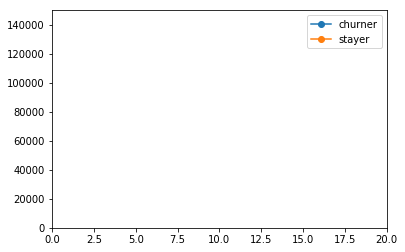

K=2


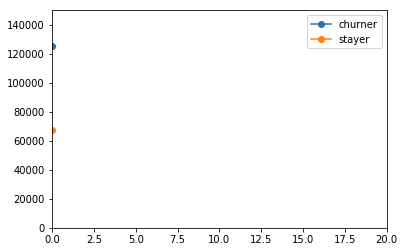

K=3


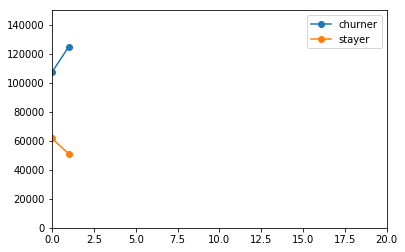

K=4


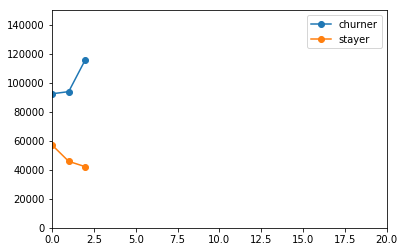

K=5


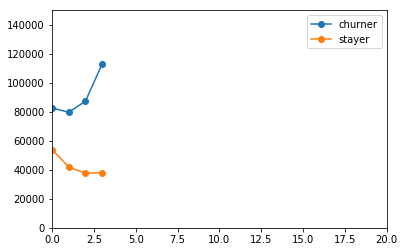

K=6


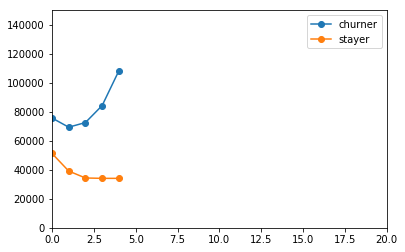

K=7


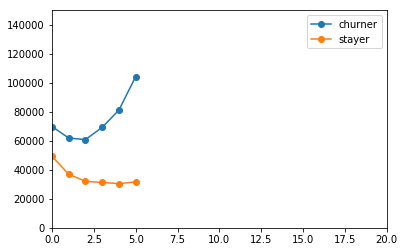

K=8


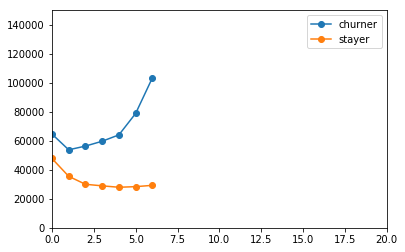

K=9


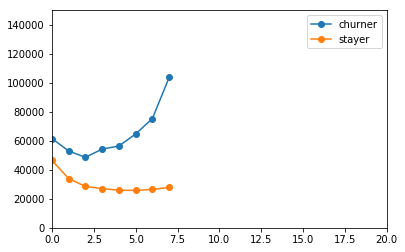

K=10


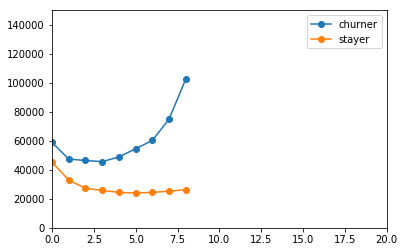

K=11


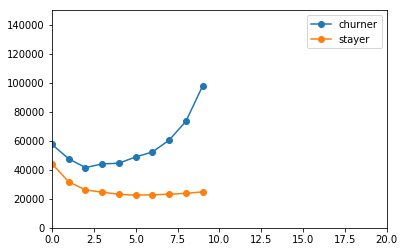

K=12


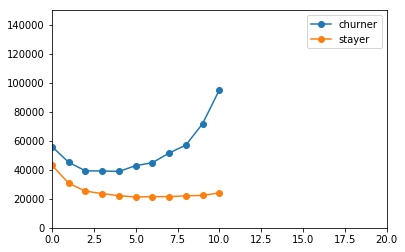

K=13


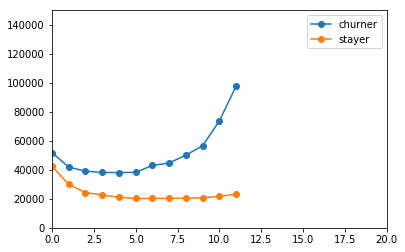

K=14


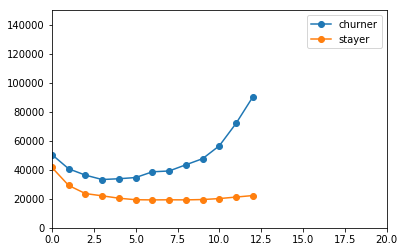

K=15


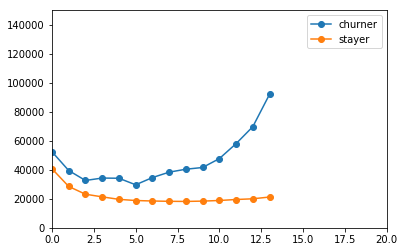

K=16


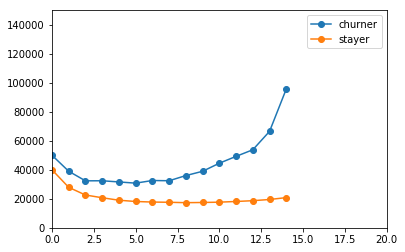

K=17


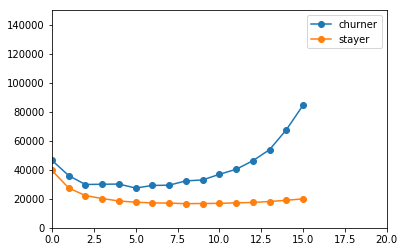

K=18


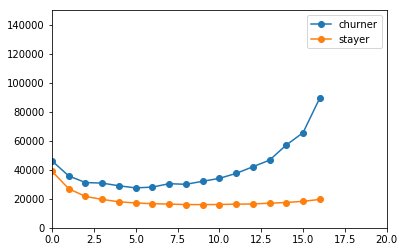

K=19


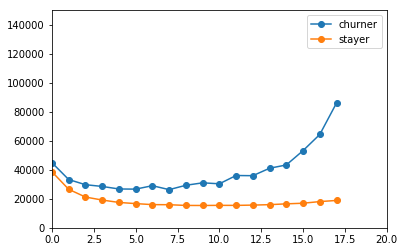

K=20


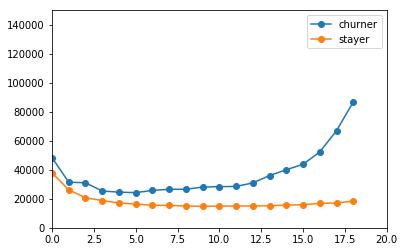

In [0]:
# Figure 2: Gap between posts
#    For a user who churns, gap between consecutive posts keeps increasing. 
#    Gaps for those who stay are much lower, and stabilize around 20,000 minutes,
#    indicating routine posting activity in every ≈2 weeks.
clist = []
slist = []
for K in list_of_K:
    subgroup = features_of_task1[K]
    churners_gap = []
    stayers_gap = []
    for i in range(2, K+1):
        gapK = 'gap{}'.format(i)
        sum_gapK = list(subgroup.groupby('is_churn')[gapK].sum())
        count_gapK = list(subgroup.groupby('is_churn')[gapK].count())
        if len(sum_gapK) < 2:
            break
        churners_gap.append(sum_gapK[1] / count_gapK[1])
        stayers_gap.append(sum_gapK[0] / count_gapK[0])

    clist.append(churners_gap)
    slist.append(stayers_gap)
    
    print("K={}".format(K))
    plt.plot(churners_gap, '-o', label='churner')
    plt.plot(stayers_gap, '-o', label='stayer')
    plt.legend()
    plt.axis((0,20,0,15e4))
    plt.show()

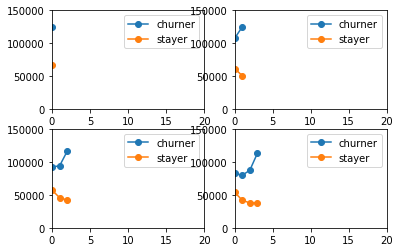

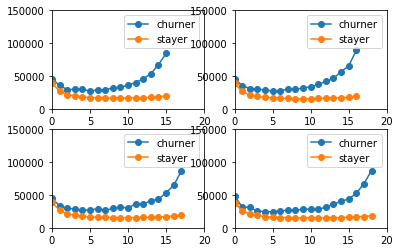

In [0]:
fig = plt.figure()
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 2, 3)
ax4 = fig.add_subplot(2, 2, 4)
axlist = [ax1, ax2, ax3, ax4]
for c, s, ax in zip(clist[1:], slist[1:], axlist):
    ax.plot(c, '-o', label='churner')
    ax.plot(s, '-o', label='stayer')
    ax.legend()
    ax.axis((0,20,0,15e4))
plt.show()

fig = plt.figure()
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 2, 3)
ax4 = fig.add_subplot(2, 2, 4)
axlist = [ax1, ax2, ax3, ax4]
for c, s, ax in zip(clist[-4:], slist[-4:], axlist):
    ax.plot(c, '-o', label='churner')
    ax.plot(s, '-o', label='stayer')
    ax.legend()
    ax.axis((0,20,0,15e4))
plt.show()

In [0]:
# Extract temporal features for task2
for T in list_of_T:
    users, posts = users_of_task2[T], posts_of_task2[T]
    features_of_task2[T]['gap1'] = getTimeGap1OfUser(users, posts)
    features_of_task2[T]['last_gap'] = getTimeLastGapOfPosts(posts).fillna(features_of_task2[T]['gap1'])
    #features_of_task2[T]['last_gap'] = getTimeLastGapOfPosts(posts).fillna(0)
    features_of_task2[T]['time_since_last_post'] = getTimeSinceLastPost(users, posts, T)
    features_of_task2[T]['mean_gap'] = getTimeMeanGap(posts)
  


3-2. Frequency features

In [0]:
# Frequency features 1: num_answers
# Frequency features 2: num_questions
def getNumAnswers(posts):
    answers = posts[posts['PostTypeId'] == 2]
    return answers.groupby('OwnerUserId')['OwnerUserId'].count()

def getNumQuestions(posts):
    questions = posts[posts['PostTypeId'] == 1]
    return questions.groupby('OwnerUserId')['OwnerUserId'].count()


In [0]:
# Frequency features 3: ans_ques_ratio
def getAnsQuesRatio(num_answers, num_questions):
    # Use Laplace Smoothing
    return (num_answers + 1) / (num_questions + 1)


In [0]:
# Frequency features 4: num_posts
def getNumPosts(posts):
    return posts.groupby('OwnerUserId')['OwnerUserId'].count().astype('float')

In [0]:
# Extract frequency features of task1
for K in list_of_K:
    users, posts = users_of_task1[K], posts_of_task1[K]
    features_of_task1[K]['num_answers'] = getNumAnswers(posts)
    features_of_task1[K]['num_questions'] = getNumQuestions(posts)
    features_of_task1[K] = features_of_task1[K].fillna({'num_answers':0, 'num_questions':0})
    features_of_task1[K]['ans_que_ratio'] = \
        getAnsQuesRatio(features_of_task1[K]['num_answers'], features_of_task1[K]['num_questions'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [0]:
# Extract frequency features of task2
for T in list_of_T:
    users, posts = users_of_task2[T], posts_of_task2[T]
    features_of_task2[T]['num_answers'] = getNumAnswers(posts)
    features_of_task2[T]['num_questions'] = getNumQuestions(posts)
    features_of_task2[T] = features_of_task2[T].fillna({'num_answers':0,'num_questions':0})
    features_of_task2[T]['ans_que_ratio'] = \
        getAnsQuesRatio(features_of_task2[T]['num_answers'], features_of_task2[T]['num_questions'])
    features_of_task2[T]['num_posts'] = getNumPosts(posts)

# Answers vs Churn probability


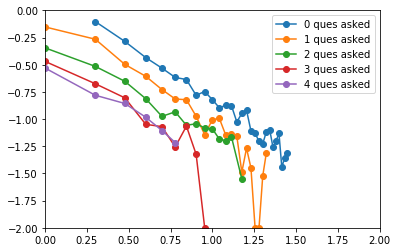

# Answers vs Churn probability


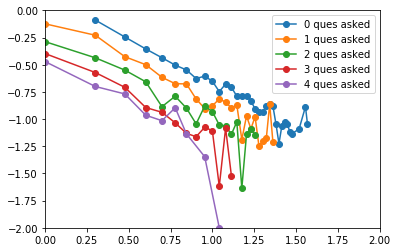

# Answers vs Churn probability


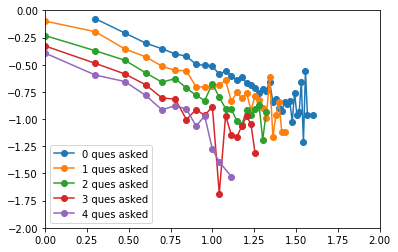

In [0]:
# Figure 3: # Answers vs Churn probability
#    The probability of churning for a user decreases the more answers s/he provides.
#    It is even lower if s/he asks more questions alongside.

min_num_users = 50
for T in list_of_T:
    task2 = features_of_task2[T]
    for num_que_ask in range(5):
        subgroup = task2[task2['num_questions'] == num_que_ask]
        churn_probs = []
        num_answers = list(set(subgroup['num_answers']))
        num_answers.sort()
        for num_ans in num_answers:
            subsubgroup = subgroup[subgroup['num_answers'] == num_ans]
            prob = sum(subsubgroup['is_churn']) / subsubgroup.shape[0]
            if subsubgroup.shape[0] >= min_num_users:
                churn_probs.append((num_ans, prob))

        plt.plot([np.log10(x[0]+1) for x in churn_probs],
                 [np.log10(x[1]+0.01) for x in churn_probs],
                 '-o',
                 label='{} ques asked'.format(num_que_ask))
    print("# Answers vs Churn probability")
    plt.legend()
    plt.axis((0,2,-2,0))
    plt.show()

3-3. Knowledge features

In [0]:
# For the fast extraction, prepare questions x answers
def preprocessForKnowledgeFeaturesForTask1(users, posts, all_posts):
    answers = posts[posts['PostTypeId'] == 2]
    questions = posts[posts['PostTypeId'] == 1]
    all_answers = all_posts[all_posts['PostTypeId'] == 2]
    all_questions = all_posts[all_posts['PostTypeId'] == 1]

    qna = answers.set_index('ParentId')\
        .join(questions, how='inner',\
             lsuffix='A', rsuffix='Q')
    
    qnta = all_answers.set_index('ParentId')\
        .join(questions, how='inner',\
              lsuffix='A', rsuffix='Q')
    
    tqna = answers.set_index('ParentId')\
        .join(all_questions, how='inner',\
              lsuffix='A', rsuffix='Q')
    
    tqnta = all_answers.set_index('ParentId')\
        .join(all_questions, how='inner',\
              lsuffix='A', rsuffix='Q')
    
    
    return answers, all_answers, questions, all_questions, qna, qnta, tqna, tqnta

In [0]:
# For the fast extraction, prepare questions x answers
def preprocessForKnowledgeFeaturesForTask2(users, posts, all_posts):
    answers = posts[posts['PostTypeId'] == 2]
    questions = posts[posts['PostTypeId'] == 1]
    all_answers = all_posts[all_posts['PostTypeId'] == 2]
    all_questions = all_posts[all_posts['PostTypeId'] == 1]

    qna = answers.set_index('ParentId')\
        .join(questions, how='inner',\
             lsuffix='A', rsuffix='Q')
    
    qnta = all_answers.set_index('ParentId')\
        .join(questions, how='inner',\
              lsuffix='A', rsuffix='Q')
    
    tqna = answers.set_index('ParentId')\
        .join(all_questions, how='inner',\
              lsuffix='A', rsuffix='Q')
    
    tqnta = all_answers.set_index('ParentId')\
        .join(all_questions, how='inner',\
              lsuffix='A', rsuffix='Q')
    
    
    return answers, all_answers, questions, all_questions, qna, qnta, tqna, tqnta

In [0]:
# Knowledge features 1: accepted_answerer_rep
def getRepOfAcceptedAnswerer(K, users, answers, all_answers, questions, all_questions, qna, qnta, tqna, tqnta):
    reputations = users.loc[:, ['Reputation']]
    rep_accepted_ans = qnta[qnta['AcceptedAnswerIdQ'] == qnta['PostIdA']]\
        .set_index('OwnerUserIdA')\
        .join(reputations, how='inner')\
        .groupby('OwnerUserIdQ')['Reputation'].mean()
    return rep_accepted_ans


In [0]:
# Knowledge features 2: max_rep_answerer 
def getMaxRepAmongAnswerer(K, users, answers, all_answers, questions, all_questions, qna, qnta, tqna, tqnta):
    reputations = users.loc[:, ['Reputation']]
    rep_max_ans = qnta.set_index('OwnerUserIdA')\
        .join(reputations, how='inner')\
        .groupby('OwnerUserIdQ')['Reputation'].max()
    return rep_max_ans


In [0]:
# Knowledge features 3: num_que_answered
def getNumQueAnswered(K, users, answers, all_answers, questions, all_questions, qna, qnta, tqna, tqnta):
    # number of questions posted by the user that got answered
    #questions = posts[posts['PostTypeId'] == 1]
    answered_questions = questions[questions['AnswerCount'] > 0]
    return answered_questions.groupby('OwnerUserId')['AnswerCount'].count()


In [0]:
# Knowledge features 4: time_for_first_ans
def getTimeForFirstAns(K, users, answers, all_answers, questions, all_questions, qna, qnta, tqna, tqnta):
    tmp = tqnta
    tmp['time_for_ans'] = (tmp['CreationDateA'] - tmp['CreationDateQ']).dt.total_seconds() / 60
    #tmp = tmp[tmp['ithQ'] == K]
    all_questions['time_for_first_ans'] = tmp.groupby(by=tmp.index)['time_for_ans'].min()
    all_questions = all_questions.fillna({'time_for_first_ans': -1})
    return all_questions[all_questions['time_for_first_ans'] >= 0].groupby('OwnerUserId')['time_for_first_ans'].min()


In [0]:
# Knowledge features 5: rep_questioner
def getAvgRepOfQuestioner(K, users, answers, all_answers, questions, all_questions, qna, qnta, tqna, tqnta):
    # Avg. reputation of the user whose question was answered
    reputations = users.loc[:, ['Reputation']]
    rep_accepted_ans = tqna.set_index('OwnerUserIdQ')\
        .join(reputations, how='inner')\
        .groupby('OwnerUserIdA')['Reputation'].mean()
    return rep_accepted_ans


In [0]:
# Knowledge features 6: rep_answerers
def getAvgRepOfAnswerer(K, users, answers, all_answers, questions, all_questions, qna, qnta, tqna, tqnta):
    # Avg. reputation of the users who answered the question
    reputations = users.loc[:, ['Reputation']]
    rep_accepted_ans = qnta.set_index('OwnerUserIdA')\
        .join(reputations, how='inner')\
        .groupby('OwnerUserIdQ')['Reputation'].mean()
    return rep_accepted_ans


In [0]:
# Knowledge features 7: rep_co_answerers
def getAvgRepOfCoAnswerer(K, users, answers, all_answers, questions, all_questions, qna, qnta, tqna, tqnta):
    reputations = users.loc[:, ['Reputation']]    
    rep_ans = answers.set_index('OwnerUserId')\
        .join(reputations, how='inner')\
        .set_index('ParentId')\
        .join(questions, how='inner', lsuffix='A', rsuffix='Q')
    avg_rep_ans = rep_ans.groupby(by=rep_ans.index)['Reputation'].mean()
    rep_co_answerer = answers.set_index('ParentId')\
        .join(avg_rep_ans, how='inner')\
        .set_index('OwnerUserId')
    return rep_co_answerer.groupby(by=rep_co_answerer.index)['Reputation'].mean()


In [0]:
# Knowledge features 8: num_answers_recvd
def getAvgNumAnsReceived(K, users, answers, all_answers, questions, all_questions, qna, qnta, tqna, tqnta):
    #questions = posts[posts['PostTypeId'] == 1]
    return questions.fillna({'AnswerCount': 0}).groupby('OwnerUserId')['AnswerCount'].mean()


In [0]:
# Extract knowledge features of task 1
for K in list_of_K:
    print("Extract knowledge features of task1(K=",K,")")
    try:
      users, posts = users_of_task1[K], posts_of_task1[K]
      answers, all_answers, questions, all_questions, qna, qnta, tqna, tqnta = preprocessForKnowledgeFeaturesForTask1(users, posts, posts_df)
      #features_of_task1[K]['accepted_answerer_rep'] = getRepOfAcceptedAnswerer(K, users, answers, all_answers, questions, all_questions, qna, qnta, tqna, tqnta)
      #features_of_task1[K]['max_rep_answerer'] = getMaxRepAmongAnswerer(K, users, answers, all_answers, questions, all_questions, qna, qnta, tqna, tqnta)
      #features_of_task1[K]['num_que_answered'] = getNumQueAnswered(K, users, answers, all_answers, questions, all_questions, qna, qnta, tqna, tqnta)
      features_of_task1[K]['time_for_first_ans'] = getTimeForFirstAns(K, users, answers, all_answers, questions, all_questions, qna, qnta, tqna, tqnta)
      #features_of_task1[K]['rep_questioner'] = getAvgRepOfQuestioner(K, users, answers, all_answers, questions, all_questions, qna, qnta, tqna, tqnta)
      #features_of_task1[K]['rep_answerers'] = getAvgRepOfAnswerer(K, users, answers, all_answers, questions, all_questions, qna, qnta, tqna, tqnta)
      #features_of_task1[K]['rep_co_answerers'] = getAvgRepOfCoAnswerer(K, users, answers, all_answers, questions, all_questions, qna, qnta, tqna, tqnta)
      #features_of_task1[K]['num_answers_recvd'] = getAvgNumAnsReceived(K, users, answers, all_answers, questions, all_questions, qna, qnta, tqna, tqnta)
    except:
      print(traceback.format_exc())
      raise

Extract knowledge features of task1(K= 1 )


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


Extract knowledge features of task1(K= 2 )
Extract knowledge features of task1(K= 3 )
Extract knowledge features of task1(K= 4 )
Extract knowledge features of task1(K= 5 )
Extract knowledge features of task1(K= 6 )
Extract knowledge features of task1(K= 7 )
Extract knowledge features of task1(K= 8 )
Extract knowledge features of task1(K= 9 )
Extract knowledge features of task1(K= 10 )
Extract knowledge features of task1(K= 11 )
Extract knowledge features of task1(K= 12 )
Extract knowledge features of task1(K= 13 )
Extract knowledge features of task1(K= 14 )
Extract knowledge features of task1(K= 15 )
Extract knowledge features of task1(K= 16 )
Extract knowledge features of task1(K= 17 )
Extract knowledge features of task1(K= 18 )
Extract knowledge features of task1(K= 19 )
Extract knowledge features of task1(K= 20 )


In [0]:
for T in list_of_T:
    print("Extract knowledge features of task2(T=)",T,")")
    users, posts = users_of_task2[T], posts_of_task2[T]
    answers, all_answers, questions, all_questions, qna, qnta, tqna, tqnta = preprocessForKnowledgeFeaturesForTask2(users, posts, posts_df)
    features_of_task2[T]['accepted_answerer_rep'] = getRepOfAcceptedAnswerer(T, users, answers, all_answers, questions, all_questions, qna, qnta, tqna, tqnta)
    features_of_task2[T]['max_rep_answerer'] = getMaxRepAmongAnswerer(T, users, answers, all_answers, questions, all_questions, qna, qnta, tqna, tqnta)
    features_of_task2[T]['num_que_answered'] = getNumQueAnswered(T, users, answers, all_answers, questions, all_questions, qna, qnta, tqna, tqnta)
    features_of_task2[T]['time_for_first_ans'] = getTimeForFirstAns(T, users, answers, all_answers, questions, all_questions, qna, qnta, tqna, tqnta)
    features_of_task2[T]['rep_questioner'] = getAvgRepOfQuestioner(T, users, answers, all_answers, questions, all_questions, qna, qnta, tqna, tqnta)
    features_of_task2[T]['rep_answerers'] = getAvgRepOfAnswerer(T, users, answers, all_answers, questions, all_questions, qna, qnta, tqna, tqnta)
    features_of_task2[T]['rep_co_answerers'] = getAvgRepOfCoAnswerer(T, users, answers, all_answers, questions, all_questions, qna, qnta, tqna, tqnta)
    features_of_task2[T]['num_answers_recvd'] = getAvgNumAnsReceived(T, users, answers, all_answers, questions, all_questions, qna, qnta, tqna, tqnta)

Extract knowledge features of task2(T=) 7 )


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


Extract knowledge features of task2(T=) 15 )
Extract knowledge features of task2(T=) 30 )


[232742.91696752375, 232739.51910961053, 224828.74883174407, 219424.34994654998, 216659.69364034018, 214143.6648884471, 209035.5089547343, 203906.35990173963, 205860.56942418564, 209521.32663203127, 201850.58632582997, 202730.09873602062, 198456.0566450437, 198158.60758758895, 199555.13967163817, 201356.25665287988, 199171.0714160373, 196800.53842392788, 199203.4811208124, 198876.1475033048]
[248900.25047372558, 245459.62412893726, 242859.13531122167, 241197.11413979915, 239425.8610849581, 237978.67999247953, 237070.02351048504, 236472.42155053376, 235654.92851706134, 234757.89289779356, 233920.4056198785, 232852.5658813382, 232173.4244765764, 231642.26558249106, 230942.07873685157, 230165.28800290814, 229511.96894627053, 228854.83805183347, 228390.09668966883, 228032.67510009275]


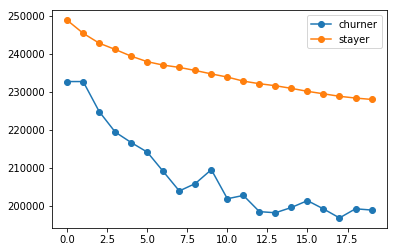

In [0]:
# Figure 4: K vs Time taken for the first answer to arrive
#  The more the time taken for a user to receive an answer, 
#  the lesser the satisfaction level and the more the chances of churning.
churners_time = []
stayers_time = []
for K in list_of_K:
    subgroup = features_of_task1[K]
    subgroup = subgroup.fillna({'time_for_first_ans': -1})
    subgroup = subgroup[subgroup['time_for_first_ans'] >= 0]
    churners = subgroup[subgroup['is_churn'] == 1]
    stayers = subgroup[subgroup['is_churn'] == 0]
    churners_time.append(churners['time_for_first_ans'].mean())
    stayers_time.append(stayers['time_for_first_ans'].mean())
    

print(churners_time)
print(stayers_time)

plt.plot(churners_time, '-o', label='churner')
plt.plot(stayers_time, '-o', label='stayer')
plt.legend()
# plt.axis((0,20,8e3,22e3))
plt.show()

3-4. Speed features

In [0]:
# Speed features 1: answering_speed
def getAnsweringSpeed(questions_df, answers_df):
    answers_df = posts[posts['PostTypeId'] == 2]
    questions_df = posts[posts['PostTypeId'] == 1]
    
    qna = answers_df.set_index('ParentId')\
        .join(questions_df, how='inner', lsuffix='A', rsuffix='Q')
    qna = qna[qna['CreationDateQ'] < qna['CreationDateA']]
    qna['time_for_ans'] = (qna['CreationDateA'] - qna['CreationDateQ']).dt.total_seconds() // 60
    return 1 / qna.groupby('OwnerUserIdA')['time_for_ans'].mean()

In [0]:
answers = posts_df[posts_df['PostTypeId'] == 2]
for K in list_of_K:
  questions = posts_of_task1[K]
  questions = [questions['PostTypeId'] == 1]
  features_of_task1[K]['answering_speed'] = getAnsweringSpeed(questions, answers)  

In [0]:
for T in list_of_T:
  posts = posts_of_task2[T]
  questions = posts[posts['PostTypeId'] == 1]
  answers = posts[posts['PostTypeId'] == 2]
  features_of_task2[T]['answering_speed'] = getAnsweringSpeed(questions, answers)

3-5. Quality features

In [0]:
# Quality features 1: ans_score
# Quality features 2: que_score
def getScoreOfAnswers(posts):
    answers = posts[posts['PostTypeId'] == 2]
    return answers.groupby('OwnerUserId')['Score'].mean()

def getScoreOfQuestions(posts):
    questions = posts[posts['PostTypeId'] == 1]
    return questions.groupby('OwnerUserId')['Score'].mean()

In [0]:
for K in list_of_K:
  posts = posts_of_task1[K]
  features_of_task1[K]['score_of_answers'] = getScoreOfAnswers(posts)
  features_of_task1[K]['score_of_questions'] = getScoreOfQuestions(posts) 

In [0]:
for T in list_of_T:
  posts = posts_of_task2[T]
  features_of_task2[T]['score_of_answers'] = getScoreOfAnswers(posts)
  features_of_task2[T]['score_of_questions'] = getScoreOfQuestions(posts) 

3-6. Consistency features

In [0]:
# Consistency features 1: ans_stddev
# Consistency features 2: que_stddev
def getStdevOfScoresOfAnswers(posts):
    answers = posts[posts['PostTypeId'] == 2]
    return answers.groupby('OwnerUserId')['Score'].std()

def getStdevOfScoresOfQuestions(posts):
    questions = posts[posts['PostTypeId'] == 1]
    return questions.groupby('OwnerUserId')['Score'].std()


In [0]:
for K in list_of_K:
  posts = posts_of_task1[K]
  features_of_task1[K]['stdev_of_answers'] = getStdevOfScoresOfAnswers(posts)
  features_of_task1[K]['stdev_of_questions'] = getStdevOfScoresOfQuestions(posts)

In [0]:
for K in list_of_T:
  posts = posts_of_task2[T]
  features_of_task2[T]['stdev_of_answers'] = getStdevOfScoresOfAnswers(posts)
  features_of_task2[T]['stdev_of_questions'] = getStdevOfScoresOfQuestions(posts)

3-7. Gratitude features

In [0]:
# Gratitude features 1: ans_comments
# Gratitude features 2: que_comments
def getAvgNumOfCommentsOfAnswers(posts):
    answers = posts[posts['PostTypeId'] == 2]
    return answers.groupby('OwnerUserId')['CommentCount'].mean()

def getAvgNumOfCommentsOfQuestions(posts):
    questions = posts[posts['PostTypeId'] == 1]
    return questions.groupby('OwnerUserId')['CommentCount'].mean()

In [0]:
for K in list_of_K:
  posts = posts_of_task1[K]
  features_of_task1[K]['avg_num_comments_of_answers'] = getAvgNumOfCommentsOfAnswers(posts)
  features_of_task1[K]['avg_num_comments_of_questions'] = getAvgNumOfCommentsOfQuestions(posts)

In [0]:
for K in list_of_T:
  posts = posts_of_task2[T]
  features_of_task2[T]['avg_num_comments_of_answers'] = getAvgNumOfCommentsOfAnswers(posts)
  features_of_task2[T]['avg_num_comments_of_questions'] = getAvgNumOfCommentsOfQuestions(posts)

3-8. Competitiveness features

In [0]:
# Competitiveness features 1: relative_rank_pos --> Strange..
def getRelativeRankPos(posts):
    # average of total # of answers for a question divided by the rank of user’s answer
    answers_df = posts[posts['PostTypeId'] == 2]
    ans_rank = answers_df.groupby('ParentId')['Score'].rank(method='average')
    ans_count = answers_df.groupby('ParentId')['Score'].transform('count')
#     answers_copy = answers_df.copy()
#     answers_copy['RelRankPos'] =  ans_count / ans_rank
    answers_copy = pd.DataFrame({
        'OwnerUserId': answers_df['OwnerUserId'],
        'RelRankPos': ans_count / ans_rank,
    })
    return answers_copy.groupby('OwnerUserId')['RelRankPos'].mean()

  

In [0]:
for K in list_of_K:
  posts = posts_of_task1[K]
  features_of_task1[K]['relative_rank_pos'] = getRelativeRankPos(posts)

In [0]:
for T in list_of_T:
  posts = posts_of_task2[T]
  features_of_task2[T]['relative_rank_pos'] = getRelativeRankPos(posts)

3-9. Content features

In [0]:
# Content features 1: ans_length
# Content features 2: que_length
    # Length is the word counts
def getAvgLengthOfAnswers(posts):
    answers = posts[posts['PostTypeId'] == 2]
    if 'BodyWordNum' in posts.columns:
        return answers.groupby('OwnerUserId')['BodyWordNum'].mean()
    return answers.groupby('OwnerUserId')['Body'].apply(lambda r: r.str.split().str.len().mean())

def getAvgLengthOfQuestions(posts):
    questions = posts[posts['PostTypeId'] == 1]
    if 'BodyWordNum' in posts.columns:
        return questions.groupby('OwnerUserId')['BodyWordNum'].mean()
    return questions.groupby('OwnerUserId')['Body'].apply(lambda r: r.str.split().str.len().mean())


In [0]:
for K in list_of_K:
  posts = posts_of_task1[K]
  features_of_task1[K]['avg_length_of_answers'] = getAvgLengthOfAnswers(posts)
  features_of_task1[K]['avg_length_of_questions'] = getAvgLengthOfQuestions(posts)

In [0]:
for T in list_of_T:
  posts = posts_of_task2[T]
  features_of_task2[T]['avg_length_of_answers'] = getAvgLengthOfAnswers(posts)
  features_of_task2[T]['avg_length_of_questions'] = getAvgLengthOfQuestions(posts)

In [0]:
# Store the whole features of task1 to Google Drive
for K in list_of_K:
    store_df_at_google_drive('task1_{}posts_features.csv'.format(K), features_of_task1[K])
    #features_of_task1[K].to_pickle('task1_{}posts_important_features.pkl'.format(K))
    #features_of_task1[K].to_csv('task1_{}posts_important_features.csv'.format(K))

Uploaded file with ID 1ItHQptklBOym-jlbHHbl9UNdZvLU64Es
Uploaded file with ID 1m0Bvmj6abNdVOTm2BN9_jWCNYfUlgvxe
Uploaded file with ID 12M9icrCJLO79lOv9ygbvMEE2KrEPww2C
Uploaded file with ID 1oXP2i5Bl-ZANts-mz6HrhPVQbEVdq4jP
Uploaded file with ID 1NGIf2MAJFJ14L_mUfAwrirqsfvC8POcG
Uploaded file with ID 1jsJQEsP3GsWOCFRjp-3ttudmf-cg1HCK
Uploaded file with ID 1lqHO5v6E7D01UTJ8izNC_LFPTaBkmXQw
Uploaded file with ID 1W1loMjWga_vbezZUR9FjanrJX2Nlf6D8
Uploaded file with ID 1ssKVepwSg6e_pak1YPkiV9gsCjIrUxhB
Uploaded file with ID 13tcSle5pwAqjaKUJlp4wd8i8Qx839duf
Uploaded file with ID 1jSNgqHVYKDjyLr8IOqpxikiZ8bq-Wc-M
Uploaded file with ID 1c092m4OXVCVj8RxYBhZm-dA7VCzmf41M
Uploaded file with ID 1IDWtXEw8YV1ZBkKvuAFm9I6Ny8xdwL3l
Uploaded file with ID 1B5WWDXH9XWORbKBq_xBjOCngGJb3MLzk
Uploaded file with ID 1FQ7OY9ZlG8pBc-MXZNxbIF_wZ34Rv8tc
Uploaded file with ID 1NSfmVTnVH-2Y3Z75cri6yuNJKa7ompsw
Uploaded file with ID 1LNbrlH5hK-luRuA8N5dcrdqGYj7Q4hiG
Uploaded file with ID 1sx_3KdmgTJISdnpjKPHFm7zeW

In [0]:
for T in list_of_T:
    store_df_at_google_drive('task2_{}posts_features.csv'.format(T), features_of_task2[T])
    #features_of_task2[T].to_pickle('task2_{}days_important_features.pkl'.format(T))
    #features_of_task2[T].to_csv('task2_{}days_important_features.csv'.format(T))

Uploaded file with ID 10jxxPcHJ55XDplgYICFU-BLqtUdDfBWx
Uploaded file with ID 1Nj6luRGBaNN4DEq2hzNEi7Nsx9DznBUr
Uploaded file with ID 1s89KdZtRxP081b5sMeXhImLE_YoAAAsu


5. Train models for each tasks with the features

    1. Decision Tree
    2. SVM (Linear)
    3. SVM (RBF)
    4. Logistic Regression

In [0]:
# Load features of task1
# You can change the runtime to use GPU. It means you should load the features which you stored
features_of_task1 = {}
list_of_K = range(1, 21)
for K in list_of_K:
  features_of_task1[K] = load_df_at_google_drive('task1_{}posts_features.csv'.format(K))

In [0]:
# Load features of task1
# You can change the runtime to use GPU. It means you should load the features which you stored
features_of_task2 = {}
list_of_T = [7, 15, 30]
for T in list_of_T:
  features_of_task2[T] = load_df_at_google_drive('task2_{}posts_features.csv'.format(T))

answering_speed                  543719

score_of_answers                 374883

score_of_questions               193957

stdev_of_answers                 568840

stdev_of_questions               568840

avg_num_comments_of_answers      374883

avg_num_comments_of_questions    193957

relative_rank_pos                374883

avg_length_of_answers            374883

avg_length_of_questions          193957

In [0]:
def fill_nan(features):
    if 'time_for_first_ans' in features.columns and np.isnan(features['time_for_first_ans']).sum(0):
        features['time_for_first_ans'] = 1 / features['time_for_first_ans']
        features['time_for_first_ans'] = features['time_for_first_ans'].replace([np.nan], 0)
    fill_constants = {
        'accepted_answerer_rep': 0,
        'max_rep_answerer': 0,
        'num_que_answered': 0, 
        'rep_questioner': 0,
        'rep_answerers': 0,
        'rep_co_answerers': 0,
        'num_answers_recvd': 0,
        'answering_speed': 0,
        'score_of_answers': 0,
        'score_of_questions': 0,
        'stdev_of_answers': 0,
        'stdev_of_questions': 0,
        'avg_num_comments_of_answers': 0,
        'avg_num_comments_of_questions': 0,
        'relative_rank_pos': 1,
        'avg_length_of_answers': 0,
        'avg_length_of_questions': 0,
    }
    return features.fillna(fill_constants)
                                                                         

In [9]:
for K in list_of_K:
    print("Fill NaN of task1(K=",K,")")
    features_of_task1[K] = fill_nan(features_of_task1[K])


Fill NaN of task1(K= 1 )
Fill NaN of task1(K= 2 )
Fill NaN of task1(K= 3 )
Fill NaN of task1(K= 4 )
Fill NaN of task1(K= 5 )
Fill NaN of task1(K= 6 )
Fill NaN of task1(K= 7 )
Fill NaN of task1(K= 8 )
Fill NaN of task1(K= 9 )
Fill NaN of task1(K= 10 )
Fill NaN of task1(K= 11 )
Fill NaN of task1(K= 12 )
Fill NaN of task1(K= 13 )
Fill NaN of task1(K= 14 )
Fill NaN of task1(K= 15 )
Fill NaN of task1(K= 16 )
Fill NaN of task1(K= 17 )
Fill NaN of task1(K= 18 )
Fill NaN of task1(K= 19 )
Fill NaN of task1(K= 20 )


In [0]:
for T in list_of_T:
    print("Fill NaN of task2(T=)",T,")")
    features_of_task2[T] = fill_nan(features_of_task2[T])


Fill NaN of task2(T=) 7 )
Fill NaN of task2(T=) 15 )
Fill NaN of task2(T=) 30 )


In [10]:
# install ThunderSVM
!wget https://developer.nvidia.com/compute/cuda/9.0/Prod/local_installers/cuda-repo-ubuntu1604-9-0-local_9.0.176-1_amd64-deb
!dpkg -i cuda-repo-ubuntu1604-9-0-local_9.0.176-1_amd64-deb
!apt-key add /var/cuda-repo-9-0-local/7fa2af80.pub
!apt-get update
!apt-get install cuda=9.0.176-1
!pip3 install thundersvm

--2019-10-21 12:38:45--  https://developer.nvidia.com/compute/cuda/9.0/Prod/local_installers/cuda-repo-ubuntu1604-9-0-local_9.0.176-1_amd64-deb
Resolving developer.nvidia.com (developer.nvidia.com)... 192.229.182.215
Connecting to developer.nvidia.com (developer.nvidia.com)|192.229.182.215|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://developer.download.nvidia.com/compute/cuda/9.0/secure/Prod/local_installers/cuda-repo-ubuntu1604-9-0-local_9.0.176-1_amd64.deb?fbvLL2ouDxhIOwT9sKg7UN_yuURctjaBHcqxXXtWFUotvHIi2zBguOvVcv6Hbn9XeLobXK4xIx4Lts0LRIbnqbO_WrGMRAfn3D-6-QMTTiGStT2d9GyXcC6ja0-KHI6rz1rSeERTMHmuHIi-m3h4oXNKB6aYbzxLJg4pN5oGzI62KuhdlxIY1wzwcdNsserEpZGOuuIGRgoJ7T75OcdC [following]
--2019-10-21 12:38:46--  https://developer.download.nvidia.com/compute/cuda/9.0/secure/Prod/local_installers/cuda-repo-ubuntu1604-9-0-local_9.0.176-1_amd64.deb?fbvLL2ouDxhIOwT9sKg7UN_yuURctjaBHcqxXXtWFUotvHIi2zBguOvVcv6Hbn9XeLobXK4xIx4Lts0LRIbnqbO_WrGMRAfn3D-6-QMTTiGStT

In [0]:
# define the models
from sklearn.tree import DecisionTreeClassifier
#from sklearn.svm import SVC
from thundersvm import SVC
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold

from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.python.framework import ops
ops.reset_default_graph()

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

seed = 1234
np.random.seed(seed)


def LogisticRegression_(*arg, **kwarg):
    kwarg['max_iter'] = 1e3
    kwarg['solver'] = 'saga'
    kwarg['n_jobs'] = 8
    return LogisticRegression(*arg, **kwarg)
  
def DecisionTreeClassifier_(*arg, **kwarg):
    return DecisionTreeClassifier(*arg, **kwarg)

  
def LogisticRegression_(*arg, **kwarg):
    kwarg['max_iter'] = 1e4
    kwarg['solver'] = 'saga'
    kwarg['n_jobs'] = 8
    return LogisticRegression(*arg, **kwarg)

  
def SVC_rbf(*arg, **kwarg):
    #exit(1)
    kwarg['kernel'] = 'rbf'
    return SVC(*arg, **kwarg)

  
def SVC_linear(*arg, **kwarg):
    #exit(1)
    kwarg['kernel'] = 'linear'
    #kwarg['max_iter'] = 1e4
    return SVC(*arg, **kwarg)
  

In [0]:
import time


def learn_model(data, train_features, target='is_churn', model=DecisionTreeClassifier, seed=seed):
    X = data[train_features]
    y = data[target]
    print(model.__name__)
            
    ### 10-fold cross validation ###
    acc_list = []
    kf = KFold(n_splits=10, shuffle=True, random_state=seed)
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        ### Under-sampling ###
        churners = y_train[y_train == 1].index
        stayers = y_train[y_train == 0].index
        n_churn = len(churners)
        n_stay = len(stayers)
        if n_churn > n_stay:
            churners = np.random.choice(churners, n_stay, replace=False)
        else:
            stayers = np.random.choice(stayers, n_churn, replace=False)
        train_index = np.array(list(churners) + list(stayers))
        X_train, y_train = X.reindex(train_index), y.reindex(train_index)

        ### Learn Model ###
        start_time = time.time()
        print("Model start to fit", time.strftime("%H:%M:%S", time.gmtime(start_time)))
        mdl = model().fit(X_train, y_train)
        elapsed_time = time.time() - start_time
        time.strftime("%H:%M:%S", time.gmtime(elapsed_time))
        pred = mdl.predict(X_test)
        acc = (pred == y_test)
        acc_list.append(sum(acc)*100/len(acc))
    return acc_list

In [0]:
# Table 2: Performance on Task 1

drop_user_columns = ['Reputation', 'CreationDate', 'LastAccessDate', 'num_posts']

# model = LogisticRegression_
#model = DecisionTreeClassifier
model = SVC_rbf

for K in list_of_K:
    start_time = time.time()
    
    print('Task 1, K={}'.format(K))
    train_features = [col for col in features_of_task1[K].columns 
                      if col not in drop_user_columns + ['is_churn']]
    #print (train_features)
    #print(len(features))
    #print(features.isnull().sum())
    acc_list = learn_model(features_of_task1[K], train_features, model=model)
    print('Accuracy: {}'.format(np.mean(acc_list)))
    print('    for each folds: {}'.format(acc_list))
    elapsed_time = time.time() - start_time
    time.strftime("%H:%M:%S", time.gmtime(elapsed_time))


Task 1, K=1
SVC_rbf
Model start to fit 12:48:35


In [0]:
# Table 3: Performance on Task 2

drop_user_columns = ['Reputation', 'CreationDate', 'LastAccessDate']

model = LogisticRegression_
#model = DecisionTreeClassifier_

for T in list_of_T:
    print('Task 2, T={}'.format(T))
    train_features = [col for col in features_of_task2[T].columns 
                      if col not in drop_user_columns + ['is_churn']]

    acc_list = learn_model(features_of_task2[T], train_features, model=model)
    print('Accuracy: {}'.format(np.mean(acc_list)))
    print('    for each folds: {}'.format(acc_list))


Task 2, T=7
LogisticRegression_


KeyboardInterrupt: ignored

In [0]:
categories_of_task1 = {
    'temporal': [],
    'frequency': ['num_answers', 'num_questions', 'ans_que_ratio'],
    'speed': ['answering_speed'],
    'quality': ['score_of_answers', 'score_of_questions'],
    'consistency': ['stdev_of_answers', 'stdev_of_questions'],
    'gratitude': ['avg_num_comments_of_comments', 'avg_num_comments_of_answers'],
    'competitiveness': ['relative_rank_pos'],
    'content': ['avg_length_of_answers', 'avg_length_of_questions'],
    'knowledge': ['accepted_answerer_rep', 'max_rep_answerer',\
                     'num_que_answered', 'time_for_first_ans',\
                      'rep_questioner', 'rep_answerers',\
                      'rep_co_answerers', 'num_answers_recvd']
}

task1_accuracy_of_category = {}

In [0]:
for name, feature_list in categories_of_task1.items():
    accuracy_of_category = []
    for K in list_of_K:
        print(name)
        if name == 'temporal':
            feature_list = ['gap{}'.format(j) for j in range(1, K+1)]
        elif name == 'frequency':
            features_list = [feat for feat in feature_list if feat != 'num_posts']
        #print(feature_list, features_of_task1[K].columns)
        train_features = [feat for feat in feature_list if feat in features_of_task1[K].columns]
        if len(train_features) == 0:
            continue
        print('\n{}, Task 1, K={}'.format(name, K))
        print('    columns: {}'.format(train_features))

        acc_list = learn_model(features_of_task1[K], train_features)
        mean_acc = np.mean(acc_list)
        accuracy_of_category.append(mean_acc)
        print('Accuracy: {}'.format(mean_acc))
        print('    for each folds: {}'.format(acc_list))

    task1_accuracy_of_category[name] = accuracy_of_category

In [0]:
# Bar Chart
for title, predictions in task1_accuracy_of_category.items():
    if len(predictions) == 0:
        continue
    n_groups = len(list_of_K)
    index = np.arange(n_groups)

    plt.bar(index, predictions, tick_label=list_of_K, align='center')

    plt.title(title)
    plt.xlim(-1, n_groups)
    plt.ylim(0, 100)
    plt.show()


In [0]:
categories_of_task2 = {
    'temporal': ['gap1', 'last_gap', 'time_since_last_post', 'mean_gap'],
    'frequency': ['num_answers', 'num_questions', 'ans_que_ratio', 'num_posts'],
    
    
    'speed': ['answering_speed'],
    'quality': ['ans_score', 'que_score'],
    'consistency': ['ans_stddev', 'que_stddev'],
    'gratitude': ['ans_comments', 'que_comments'],
    'competitiveness': ['relative_rank_pos'],
    'content': ['ans_length', 'que_length'],
    'knowledge': ['accepted_answerer_rep', 'max_rep_answerer',
                      'num_que_answered', 'time_for_first_ans',
                      'rep_questioner', 'rep_answerers',
                      'rep_co_answerers', 'num_answers_recvd'],
}
task2_accuracy_of_category = {}

In [0]:

### Category Analysis - Task 2 ###
for name, feature_list in categories_of_task2.items():
    accuracy_of_category = []
    for T in list_of_T:
        train_features = [feat for feat in feature_list if feat in features_of_task2[T].columns]
        if len(train_features) == 0:
            continue
        print('\n{}, Task 2, T={}'.format(name, T))
        print('    columns: {}'.format(train_features))

        acc_list = learn_model(features_of_task2[T], train_features)
        mean_acc = np.mean(acc_list)
        accuracy_of_category.append(mean_acc)
        print('Accuracy: {}'.format(mean_acc))
        print('    for each folds: {}'.format(acc_list))

    task2_accuracy_of_category[name] = accuracy_of_category


temporal, Task 2, T=7
    columns: ['gap1', 'last_gap', 'time_since_last_post', 'mean_gap']
DecisionTreeClassifier
Accuracy: 66.1855029146665
    for each folds: [65.92125692304127, 65.86100618728709, 66.2379495736003, 66.13134964775676, 66.33296255098257, 66.04097144975898, 66.4117538005191, 66.29356692621431, 66.40480163144234, 66.21941045606229]

temporal, Task 2, T=15
    columns: ['gap1', 'last_gap', 'time_since_last_post', 'mean_gap']
DecisionTreeClassifier
Accuracy: 67.30585406236311
    for each folds: [67.16544577452207, 66.93317848847597, 67.20341254243344, 67.39547972127926, 67.50044666785779, 67.6456137216366, 67.32104969290899, 67.3322166387493, 67.48855388051368, 67.07314349525404]

temporal, Task 2, T=30
    columns: ['gap1', 'last_gap', 'time_since_last_post', 'mean_gap']
DecisionTreeClassifier
Accuracy: 68.29433353330327
    for each folds: [68.49571216712876, 68.39684484277946, 68.13893008360736, 68.12388505598899, 68.38179981516109, 68.48281642917016, 68.36030691856

In [0]:
# Bar Chart
for title, predictions in task2_accuracy_of_category.items():
    if len(predictions) == 0:
        continue
    n_groups = len(list_of_T)
    index = np.arange(n_groups)

    plt.bar(index, predictions, tick_label=list_of_T, align='center')

    plt.title(title)
    plt.xlim(-1, n_groups)
    plt.ylim(50, 80)
    plt.show()


In [0]:
### Temporal Feature Analysis - Task 1 ###
temporal_analysis_feature_func = {
    'gapK': lambda K: ['gap{}'.format(j) for j in range(1, K+1)],
    'last_gap': lambda K: ['gap{}'.format(K)]
}


task1_accuracy_with_time_gap = {}
for K in list_of_K:
    accuracy_with_time_gap = []
    for name, feature_func in temporal_analysis_feature_func.items():
        train_features = [feat for feat in feature_list if feat in features_of_task1[K].columns]
        if len(train_features) == 0:
            continue
        print('\n{}, Task 1, K={}'.format(name, K))
        print('    columns: {}'.format(train_features))

        acc_list = learn_model(features_of_task1[K], train_features)
        mean_acc = np.mean(acc_list)
        accuracy_with_time_gap.append(mean_acc)
        print('Accuracy: {}'.format(mean_acc))
        print('    for each folds: {}'.format(acc_list))

    task1_accuracy_with_time_gap[K] = accuracy_with_time_gap

In [0]:
# Table 4: Temporal gap features analysis

for K, acc in task1_accuracy_with_time_gap.items():
    print(K, acc)